# Problem Set 3, due May 2 at 11:59am (i.e., noon).

### Before You Start

Make sure the following libraries load correctly (hit Ctrl-Enter). Note that while you are loading several powerful libraries, including machine learning libraries, the goal of this problem set is to implement several algorithms from scratch. In particular, you should *not* be using any built-in libraries for nearest neighbors, distance metrics, or cross-validation -- your mission is to write those algorithms in Python! Part 1 will be relatively easy; Part 2 will take more time.

*Also note:* For this assignment we are requiring you to use base **matplotlib** - not Seaborn or other packages. This will help you become familiar with techniques for maintaining fine-grained control over your data visualizations. It will also help our graders, who spent countless hours trying to make various versions import for grading.

In [2]:
import IPython
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib
import sklearn

---

## Introduction to the assignment

For this assignment, you will be using the [Boston Housing Prices Data Set](http://archive.ics.uci.edu/ml/datasets/Housing).  Please read about the dataset carefully before continuing.  Use the following commands to load the dataset:


In [62]:
from sklearn.datasets import load_boston
bdata = load_boston()

# Convert Boston dataset to a data frame
boston_df = pd.DataFrame(bdata.data)
boston_df.columns = bdata.feature_names[:]
boston_df['MEDV'] = bdata.target

[[  0  18   2 ...,  15 396   4]
 [  0   0   7 ...,  17 396   9]
 [  0   0   7 ...,  17 392   4]
 ..., 
 [  0   0  11 ...,  21 396   5]
 [  0   0  11 ...,  21 393   6]
 [  0   0  11 ...,  21 396   7]]


In [ ]:
print bdata.data.all

---

## Part 1: Experimental Setup

The goal of the next few sections is to design an experiment to predict the median home value for an instance in the data.
Before beginning the "real" work, refamiliarize yourself with the dataset.

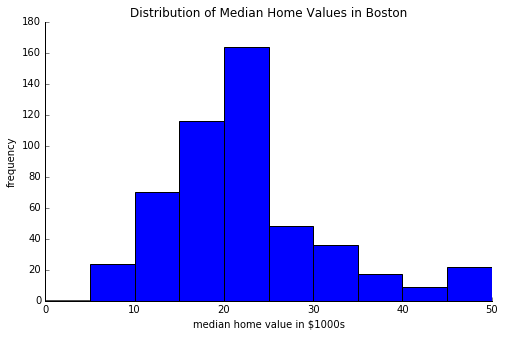

In [5]:
# prepare IPython to work with matplotlib and import the library to something convenient
%matplotlib inline  
import matplotlib.pyplot as plt  

# edit the code below to make the graph look good
def simple_axes(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

plt.figure(figsize=(8,5))
plt.hist(bdata.target, bins=np.arange(0, 55, 5))
plt.title('Distribution of Median Home Values in Boston')
plt.xlabel('median value of owner-occupied homes in $1000's')
plt.ylabel('frequency')
simple_axes(plt.axes())

### 1.1: Scatter plot of housing prices and crime

Use matplotlib to create a scatter plot that shows the relationship between the median value of the home (y-axis) and the per-capita crime rate (x-axis).  Properly label your axes, and make sure that your graphic looks polished and professional. No excuses if you don't get it right this time around!


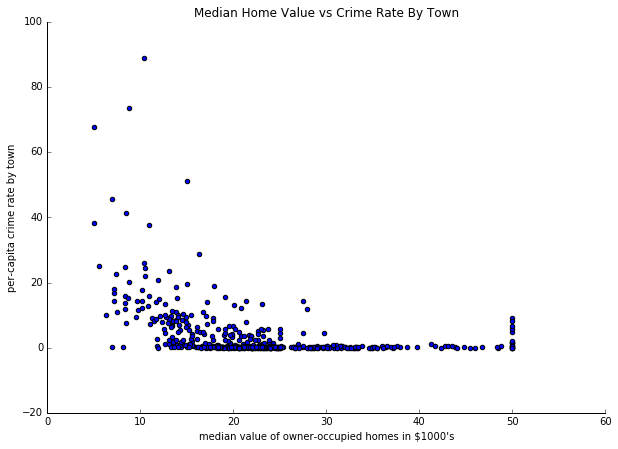

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(boston_df.MEDV, boston_df.CRIM)
plt.title('Median Home Value vs Crime Rate By Town')
plt.xlabel('median value of owner-occupied homes in $1000\'s')
plt.ylabel('per-capita crime rate by town')
simple_axes(plt.axes())

### 1.2 Begin by writing a function to compute the Root Mean Squared Error for a list of numbers

You can find the sqrt function in the Numpy package. Furthermore the details of RMSE can be found on [Wikipedia](http://en.wikipedia.org/wiki/Root-mean-square_deviation)



In [146]:
def compute_rmse(predictions, yvalues):
    """
    Function
    --------
    compute_rmse

    Given two arrays, one of actual values and one of predicted values,
    compute the Roote Mean Squared Error

    Parameters
    ----------
    predictions : array
        Array of numerical values corresponding to predictions for each of the N observations

    yvalues : array
        Array of numerical values corresponding to the actual values for each of the N observations

    Returns
    -------
    rmse : int
        Root Mean Squared Error of the prediction

    Example
    -------
    >>> print compute_rmse((2,2,3),(0,2,6)
    2.16
    """
    if len(predictions) != len(yvalues):
        raise Exception('Trying to compute RMSE on two collections of different lengths.')

    predictions = np.asarray(predictions, dtype=np.float64)
    yvalues = np.asarray(yvalues, dtype=np.float64)
    
    sum_rmse = np.square(np.subtract(predictions, yvalues)).sum()
    rmse = np.divide(sum_rmse, len(predictions))
    return np.sqrt(rmse)


2.2803508502


### 1.3 Divide your data into training and testing datasets

Randomly select 66% of the data and put this in a training dataset (call this "bdata_train"), and place the remaining 34% in a testing dataset (call this "bdata_test")


In [145]:
# leave the following line untouched, it will help ensure that your "random" split is the same "random" split used by the rest of the class
np.random.seed(seed=13579)

train_size = int(np.round((len(bdata.data) * 0.66)))

# enter your code here
bdata_train_indices = np.random.choice(np.arange(len(bdata.data)), train_size, replace=False)
bdata_train_df = boston_df.loc[bdata_train_indices]
bdata_test_df = boston_df.drop(bdata_train_indices)

bdata_train_df.head()
bdata_test_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9
10,0.22489,12.5,7.87,0.0,0.524,6.377,94.3,6.3467,5.0,311.0,15.2,392.52,20.45,15.0
11,0.11747,12.5,7.87,0.0,0.524,6.009,82.9,6.2267,5.0,311.0,15.2,396.90,13.27,18.9


### 1.4 Use a very bad baseline for prediction, and compute RMSE

Create a model that predicts, for every observation x_i, that the median home value is the average (mean) of the median values for all instances in the training set.  Compute the RMSE on the training set.  Now compute the RMSE on the test data set (but use the model you trained on the training set!).  How does RMSE compare for training vs. testing datasets? Is this what you expected, and why?

In [149]:
# enter your code her
predicted_home_values_train = np.repeat(bdata_train_df.MEDV.mean(),
                                        len(bdata_train_df))
print 'RMSE on training set:', compute_rmse(predicted_home_values_train, bdata_train_df.MEDV)
print 'RMSE on testing set:', compute_rmse(predicted_home_values_train[0:len(bdata_test_df)],
                                           bdata_test_df.MEDV)


RMSE on training set: 8.57443441541
RMSE on testing set: 10.3092622563


We get a higher RMSE than the training set for the testing set vs our simple model. This is congruent with our expectations since we used the mean of the training set median house values to predict the outcome. Therefore, it makes sense that we would see a lower RMSE when we compare our predicted values with the training set values.

---

## Part 2: Nearest Neighbors


### 2.1 Nearest Neighbors: Distance function
Let's try and build a machine learning algorithm to beat the "Average Value" baseline that you computed above.  Soon you will implement the Nearest Neighbor algorithm, but first you need to create a distance metric to measure the distance (and similarity) between two instances.  Write a generic function to compute the L-Norm distance (called the [*p*-norm](http://en.wikipedia.org/wiki/Norm_(mathematics) distance on Wikipedia). Verify that your function works by computing the Euclidean distance between the points (3,4) and (6,8).

In [160]:
"""
Function
--------
distance

Given two instances and a value for L, return the L-Norm distance between them

Parameters
----------
x1, x2 : array
    Array of numerical values corresponding to predictions for each of the N observations

L: int
    Value of L to use in computing distances

Returns
-------
dist : int
    The L-norm distance between instances

Example
-------
>>> print distance((3,4),(6,8),2)
7

"""
def distance(x1, x2, L):
    if len(x1) != len(x2):
        raise Exception('Trying to compute distance on two collections of different lengths.')

    return np.power(np.power(np.subtract(x1, x2), L).sum(), 1.0 / L)


5.0


### 2.2 Basic Nearest Neighbor algorithm

Now things get fun.  Your task is to implement a basic nearest neighbor algorithm from scratch.  Your simple model will use two input features (CRIM and RM) and a single output (MEDV).  In other words, you are modelling the relationship between median home value and crime rates and house size.

Use your training data (bdata_train) to "fit" your model, although as you know, with Nearest Neighbors there is no real training, you just need to keep your training data in memory.  Write a function that predicts, for each instance in the testing data (bdata_test), the median home value using the nearest neighbor algorithm we discussed in class.  Since this is a small dataset, you can simply compare your test instance to every instance in the training set, and return the MEDV value of the closest training instance.  Have your function take L as an input, where L is passed to the distance function.

Compute the RMSE for the Nearest Neighbor predictions on the test set, using the Euclidean distance.  Report an estimate of the total time taken by your code to predict the nearest neighbors for all the values in the test data set.

In [21]:
"""
# write your function specification here!
"""
import time
def nneighbor(..., L):
    start_time = time.time()
    #your code here

    print "Time taken: " + str(round(time.time() - start_time,2)) + " seconds"
    return rmse

#your additional code here

### 2.3 Results and Normalization

If you were being astute, you would have noticed that we never normalized our features -- a big no-no with Nearest Neighbor algorithms.  Write a generic normalization function that takes as input an array of values for a given feature, and returns the normalized array (subtract the mean and divide by the standard deviation).

Re-run the Nearest Neighbor algorithm on the normalized dataset (still just using CRIM and RM as input), and compare the RMSE from this method with your previous RMSE evaluations.

*NOTE*: To normalize properly, best practice is to compute the mean and standard deviation on the training set, and use these values to normalize the testing dataset. However, for this problem set, it is okay if you separately normalize each dataset using the respective mean and standard deviation.

In [ ]:
"""
# write your function specification here!
"""
def normalize(raw_data):
    #your code here
    return normalized_data

#your additional code here

*enter your observations here*

### 2.4 Optimization

A lot of the decisions we've made so far have been arbitrary.  Try to increase the performance of your nearest neighbor algorithm by adding features that you think might be relevant, and by using different values of L in the distance function.  Try a model that uses a different set of 2 features, then try at least one model that uses more than 4 features, then try using a different value of L.  If you're having fun, try a few different combinations of features and L!

What combination of features and distance function provide the lowest RMSE?  Do your decisions affect the running time of the algorithm?

In [ ]:
# enter your code here

*enter your observations here*

### 2.5 Cross-Validation

The more you tinkered with your features and distance function, the higher the risk that you overfit your training data.  To prevent this sort of overfitting, you need to use cross-validation (see K-fold [cross-validation](http://en.wikipedia.org/wiki/Cross-validation_(statistics)).  Here you must implement a simple k-fold cross-validation algorithm yourself.  The function you write here will be used several more times in this problem set, so do your best to write efficient code! (Note that the sklearn package has a built-in [K-fold](http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation) iterator -- you should *not* be invoking that or any related algorithms in this section of the problem set.)

Use 10-fold cross-validation and report the average RMSE for Nearest Neighbors using Euclidean distance with CRIM and RM input features, as well as the total running time for the full run of 10 folds.  In other words, randomly divide your dataset into 10 equally-sized samples, and for each of 10 iterations (the "folds"), use 9 samples as "training data" (even though there is no training in k-NN!), and the remaining 1 sample for testing.  Compute the RMSE of that particular test set, then move on to the next iteration.  Report the average RMSE across the 10 iterations.

In [64]:
# enter your code here

### 2.6 K-Nearest Neighbors Algorithm

Implement the K-Nearest Neighbors algorithm.  Using 10-fold cross validation, report the RMSE for K=3 and the running time of the algorithm.

In [64]:
"""
# write your function specification here!
"""
def knn(..., L, K):
    # enter your code here
    return rmse

# enter your additional code here

### 2.7 Using cross validation to find K

What is the best choice of K?  Compute the RMSE for values of K between 1 and 25 using 10-fold cross-validation.  Use the following features in your model, and don't forget to normalize: CRIM, ZN, RM, AGE, DIS, TAX.  Create a graph that shows how RMSE changes as K increases from 1 to 25.  Label your axes, and summarize what you see.  What do you think is a reasonable choice of K for this model?

In [ ]:
# enter your code here

*Enter your observations here*

### Extra-Credit: Forward selection

Thus far the choice of predictor variables has been rather arbitrary. For extra credit, implement a basic [forward selection](http://www.stat.ubc.ca/~rollin/teach/643w04/lec/node41.html) algorithm to progressively include features that decrease the cross-validated RMSE of the model. Note that the optimal value of K may be different for each model, so you may want to use cross-validation to choose K each time (but it is also fine if you fix K at the optimal value from 2.7).  Create a graph that shows RMSE as a function of the number of features in the model. Label each point on the x-axis with the name of the feature that is added at that step in the forward selection algorithm. *(For instance, if the optimal single-feature model has CRIM with RMSE = 10, and the optimal two-feature model has CRIM+ZN with RMSE=9, the first x-axis label will say CRIM and the second x-axis lable with say ZN)*